In [2]:
import os
import sys
import glob
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

try:
    import kagglehub
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    import kagglehub

try:
    import soundfile as sf
except ImportError:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "soundfile"])
    import soundfile as sf

In [17]:
CONFIG = {
    "batch_size": 8,
    "lr": 5e-4,
    "epochs": 10,
    "hidden_size": 256,
    "layers": 2,
    "n_mels": 13,
    "blank_idx": 0,
    "synthetic": False
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [4]:
def download_data():
    print("Fetching TIMIT...")
    try:
        path = kagglehub.dataset_download("mfekadu/darpa-timit-acousticphonetic-continuous-speech")
        print(f"Data located at: {path}")
        CONFIG["synthetic"] = False
        return path
    except:
        print("Download failed. Using synthetic mode.")
        CONFIG["synthetic"] = True
        return "./data"

DATA_ROOT = download_data()

TIMIT_PHONEMES = [
    'aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ay', 'b', 'ch', 'd', 'dh', 'dx', 'eh', 'er', 'ey',
    'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'ow', 'oy', 'p', 'r', 's',
    'sh', 't', 'th', 'uh', 'uw', 'v', 'w', 'y', 'z', 'zh', 'sil', 'epi', 'h#', 'q', 'cl', 'vcl']

Fetching TIMIT...
Using Colab cache for faster access to the 'darpa-timit-acousticphonetic-continuous-speech' dataset.
Data located at: /kaggle/input/darpa-timit-acousticphonetic-continuous-speech


In [5]:
class Tokenizer:
    def __init__(self, token_list):
        self.t2i = {"<BLANK>": 0}
        self.i2t = {0: "<BLANK>"}
        for i, t in enumerate(token_list):
            self.t2i[t] = i + 1
            self.i2t[i + 1] = t

    def encode(self, labels):
        return [self.t2i.get(l, 0) for l in labels if l in self.t2i]

    def decode(self, indices):
        return [self.i2t[i] for i in indices if i in self.i2t and i != 0]

tokenizer = Tokenizer(TIMIT_PHONEMES)

class TimitLoader(Dataset):
    def __init__(self, root, split='TRAIN', is_synthetic=False):
        self.synthetic = is_synthetic
        self.files = []

        self.features = torchaudio.transforms.MFCC(
            sample_rate=16000, n_mfcc=CONFIG["n_mels"]
        )

        if not self.synthetic:
            split_dir = None
            for r, d, f in os.walk(root):
                for folder in d:
                    if folder.upper() == split.upper():
                        split_dir = os.path.join(r, folder)
                        break

            if split_dir:
                all_wavs = sorted(glob.glob(os.path.join(split_dir, "**", "*.WAV"), recursive=True))
                self.files = [x for x in all_wavs if "SA" not in os.path.basename(x).upper()]
                print(f"Loaded {len(self.files)} files for {split}")
            else:
                print(f"Warning: {split} directory not found.")

    def __len__(self):
        return len(self.files) if not self.synthetic else 100

    def __getitem__(self, idx):
        if self.synthetic:
            length = torch.randint(10000, 25000, (1,)).item()
            sig = torch.randn(1, length)
            feats = self.features(sig).squeeze(0).transpose(0, 1)
            lbl_len = torch.randint(5, 10, (1,)).item()
            lbls = torch.randint(1, len(TIMIT_PHONEMES), (lbl_len,))
            return feats, lbls

        path = self.files[idx]
        try:
            data, sr = sf.read(path)
            raw_audio = torch.tensor(data).float()

            if raw_audio.dim() == 1:
                raw_audio = raw_audio.unsqueeze(0)
            elif raw_audio.shape[0] > raw_audio.shape[1]:
                raw_audio = raw_audio.t()

            if sr != 16000:
                resampler = torchaudio.transforms.Resample(sr, 16000)
                raw_audio = resampler(raw_audio)

            mfcc = self.features(raw_audio).squeeze(0).transpose(0, 1)

            phn_file = path.replace(".WAV", ".PHN")
            if not os.path.exists(phn_file):
                phn_file = os.path.splitext(path)[0] + ".phn"

            labels = []
            if os.path.exists(phn_file):
                with open(phn_file, 'r') as f:
                    content = f.read().strip().split('\n')
                    labels = [line.split()[-1] for line in content]

            label_tensor = torch.tensor(tokenizer.encode(labels), dtype=torch.long)
            return mfcc, label_tensor

        except Exception:
            return torch.zeros(10, CONFIG["n_mels"]), torch.tensor([], dtype=torch.long)

In [6]:
def pad_batch(batch):
    batch = [x for x in batch if x[1].shape[0] > 0]
    if not batch: return None

    xs, ys = zip(*batch)
    x_lens = torch.tensor([len(x) for x in xs], dtype=torch.long)
    y_lens = torch.tensor([len(y) for y in ys], dtype=torch.long)

    x_pad = pad_sequence(xs, batch_first=True)
    y_pad = pad_sequence(ys, batch_first=True, padding_value=-1)

    return x_pad, y_pad, x_lens, y_lens

In [7]:
class RecurrentPhonemeModel(nn.Module):
    def __init__(self, input_sz, hid_sz, n_layers, vocab_count):
        super().__init__()
        self.norm = nn.LayerNorm(input_sz)
        self.rnn = nn.LSTM(
            input_size=input_sz,
            hidden_size=hid_sz,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        self.classifier = nn.Linear(hid_sz * 2, vocab_count)

    def forward(self, x):
        x = self.norm(x)
        out, _ = self.rnn(x)
        logits = self.classifier(out)
        return F.log_softmax(logits, dim=2)

In [8]:
def safe_log_add(a, b):
    if a == -float('inf'): return b
    if b == -float('inf'): return a
    return max(a, b) + math.log1p(math.exp(-abs(a - b)))

In [9]:
def forward_variable_alpha(log_probs, target_seq, blank_token=0):
    seq_len, n_classes = log_probs.shape
    label_len = len(target_seq)

    ext_labels = [blank_token]
    for l in target_seq:
        ext_labels.extend([l.item(), blank_token])
    ext_labels = torch.tensor(ext_labels, device=log_probs.device)
    S = len(ext_labels)

    log_alpha = torch.full((seq_len, S), -float('inf'), device=log_probs.device)

    log_alpha[0, 0] = log_probs[0, ext_labels[0]]
    if S > 1:
        log_alpha[0, 1] = log_probs[0, ext_labels[1]]

    for t in range(1, seq_len):
        for s in range(S):
            current_emit = log_probs[t, ext_labels[s]]

            prev_sum = log_alpha[t-1, s]

            if s - 1 >= 0:
                prev_sum = safe_log_add(prev_sum, log_alpha[t-1, s-1])

            if s - 2 >= 0:
                if ext_labels[s] != blank_token and ext_labels[s] != ext_labels[s-2]:
                    prev_sum = safe_log_add(prev_sum, log_alpha[t-1, s-2])

            log_alpha[t, s] = prev_sum + current_emit

    final_score = safe_log_add(log_alpha[-1, -1], log_alpha[-1, -2])
    return final_score

In [10]:
def greedy_decoder(log_probs):
    preds = torch.argmax(log_probs, dim=1)
    path = []
    last = -1
    for p in preds:
        val = p.item()
        if val != last and val != 0:
            path.append(val)
        last = val
    return path

In [11]:
def beam_search_decoder(log_probs, beam_size=5):
    T, C = log_probs.shape
    prev_beam = {(): (0.0, -float('inf'))}

    for t in range(T):
        next_beam = {}

        for seq, (pb, pnb) in prev_beam.items():
            p_total = safe_log_add(pb, pnb)

            emit_blank = log_probs[t, 0].item()

            n_pb = p_total + emit_blank

            if seq in next_beam:
                old_pb, old_pnb = next_beam[seq]
                next_beam[seq] = (safe_log_add(old_pb, n_pb), old_pnb)
            else:
                next_beam[seq] = (n_pb, -float('inf'))

            for c in range(1, C):
                emit_c = log_probs[t, c].item()

                if len(seq) > 0 and seq[-1] == c:
                    new_seq_ext = seq + (c,)
                    score_ext = pb + emit_c

                    if new_seq_ext in next_beam:
                        opb, opnb = next_beam[new_seq_ext]
                        next_beam[new_seq_ext] = (opb, safe_log_add(opnb, score_ext))
                    else:
                        next_beam[new_seq_ext] = (-float('inf'), score_ext)

                    score_col = pnb + emit_c
                    if seq in next_beam:
                        opb, opnb = next_beam[seq]
                        next_beam[seq] = (opb, safe_log_add(opnb, score_col))
                    else:
                        next_beam[seq] = (-float('inf'), score_col)

                else:
                    new_seq = seq + (c,)
                    score_new = p_total + emit_c

                    if new_seq in next_beam:
                        opb, opnb = next_beam[new_seq]
                        next_beam[new_seq] = (opb, safe_log_add(opnb, score_new))
                    else:
                        next_beam[new_seq] = (-float('inf'), score_new)

        items = list(next_beam.items())
        items.sort(key=lambda x: safe_log_add(x[1][0], x[1][1]), reverse=True)
        prev_beam = dict(items[:beam_size])

    best_seq = list(prev_beam.keys())[0]
    return list(best_seq)

In [12]:
def levenshtein_error(ref, hyp):
    n = len(ref)
    m = len(hyp)

    matrix = torch.zeros((n + 1, m + 1))

    for i in range(n + 1): matrix[i, 0] = i
    for j in range(m + 1): matrix[0, j] = j

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            if ref[i-1] == hyp[j-1]:
                cost = 0
            else:
                cost = 1

            matrix[i, j] = min(
                matrix[i-1, j] + 1,
                matrix[i, j-1] + 1,
                matrix[i-1, j-1] + cost
            )

    dist = matrix[n, m].item()
    return dist / n if n > 0 else 0

In [13]:
train_set = TimitLoader(DATA_ROOT, 'TRAIN', CONFIG["synthetic"])
test_set = TimitLoader(DATA_ROOT, 'TEST', CONFIG["synthetic"])

train_dl = DataLoader(train_set, batch_size=CONFIG["batch_size"], shuffle=True, collate_fn=pad_batch)
test_dl = DataLoader(test_set, batch_size=1, shuffle=False, collate_fn=pad_batch)

net = RecurrentPhonemeModel(CONFIG["n_mels"], CONFIG["hidden_size"], CONFIG["layers"], len(TIMIT_PHONEMES) + 1)
net.to(device)

opt = optim.AdamW(net.parameters(), lr=CONFIG["lr"])
criterion = nn.CTCLoss(blank=0, reduction='mean')

/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:582: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Loaded 3696 files for TRAIN
Loaded 1344 files for TEST


In [18]:
metrics = []

for e in range(CONFIG["epochs"]):
    net.train()
    total_loss = 0
    steps = 0

    for batch in train_dl:
        if not batch: continue

        x, y, lx, ly = batch
        x, y = x.to(device), y.to(device)

        opt.zero_grad()

        log_probs = net(x)

        loss = criterion(log_probs.permute(1, 0, 2), y, lx, ly)

        if not torch.isnan(loss) and not torch.isinf(loss):
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            opt.step()
            total_loss += loss.item()
            steps += 1

    if steps > 0:
        avg = total_loss / steps
        metrics.append(avg)
        print(f"Epoch {e+1}: Loss = {avg:.4f}")

Epoch 1: Loss = 2.4718
Epoch 2: Loss = 1.8467
Epoch 3: Loss = 1.5303
Epoch 4: Loss = 1.3460
Epoch 5: Loss = 1.2290
Epoch 6: Loss = 1.1386
Epoch 7: Loss = 1.0652
Epoch 8: Loss = 1.0011
Epoch 9: Loss = 0.9456
Epoch 10: Loss = 0.8930


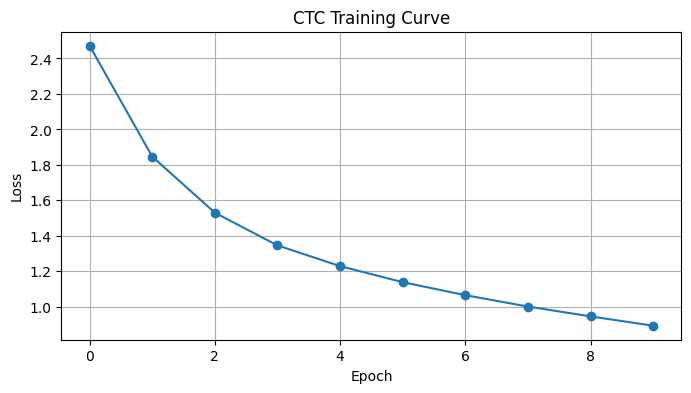

In [19]:
plt.figure(figsize=(8,4))
plt.plot(metrics, marker='o', linestyle='-')
plt.title("CTC Training Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [29]:
net.eval()

total_wer = 0
count = 0
viz_data = None

with torch.no_grad():
    for i, batch in enumerate(test_dl):
        if not batch: continue

        if i >= 10:
            break

        x, y, lx, ly = batch
        x = x.to(device)

        output = net(x)
        single_output = output[0]

        target = y[0].tolist()
        target = [t for t in target if t != -1]

        if i < 3:
            score = forward_variable_alpha(single_output, torch.tensor(target).to(device))
            beam_res = beam_search_decoder(single_output, beam_size=4)
        else:
            score = 0.0
            beam_res = []

        greedy_res = greedy_decoder(single_output)

        err = levenshtein_error(target, greedy_res)
        total_wer += err
        count += 1

        if i <= 10:
            print(f"\nSample {i}:")
            print(f"Log Likelihood: {score:.2f}")
            print(f"True:   {tokenizer.decode(target)}")
            print(f"Greedy: {tokenizer.decode(greedy_res)}")
            print(f"Beam:   {tokenizer.decode(beam_res)}")
            print(f"PER:    {err:.2f}")

        if i == 0:
            viz_data = single_output.cpu().numpy()

if count > 0:
    print(f"\nMean Phoneme Error Rate: {total_wer/count:.4f}")


Sample 0:
Log Likelihood: -49.01
True:   ['h#', 'hh', 'ih', 'z', 'k', 'ae', 't', 'n', 'w', 'ax', 's', 'th', 'ih', 'n', 'ae', 'n', 'ae', 'g', 'er', 'd', 'n', 'ih', 'z', 'b', 'y', 'dx', 'f', 'b', 'uw', 't', 's', 'epi', 'w', 'w', 'ao', 'r', 'n', 'n', 'epi', 'sh', 'ae', 'b', 'iy', 'h#']
Greedy: ['h#', 'q', 'ih', 's', 'k', 'aw', 't', 'w', 'ax', 's', 't', 'ih', 'm', 'n', 'd', 'er', 'd', 'eh', 'n', 'z', 'b', 'y', 'f', 'b', 'v', 's', 'epi', 'w', 'ax', 'w', 'ao', 'r', 'q', 'n', 'sh', 'aw', 'b', 'iy', 'h#']
Beam:   ['h#', 'q', 'ih', 's', 'k', 'aw', 't', 'w', 'ax', 's', 't', 'ih', 'm', 'n', 'ey', 'd', 'er', 'd', 'eh', 'n', 'z', 'b', 'y', 'f', 'b', 'v', 's', 'epi', 'w', 'ax', 'w', 'ao', 'r', 'q', 'n', 'sh', 'aw', 'b', 'iy', 'h#']
PER:    0.41

Sample 1:
Log Likelihood: -34.47
True:   ['h#', 'dh', 'r', 'iy', 'z', 'ax', 'n', 'z', 'f', 'dh', 'ih', 's', 'd', 'ay', 'v', 's', 'iy', 'm', 'd', 'f', 'uw', 'l', 'sh', 'epi', 'n', 'aw', 'h#']
Greedy: ['h#', 'dh', 'v', 'r', 'iy', 's', 's', 'f', 'r', 'ih', 'dh

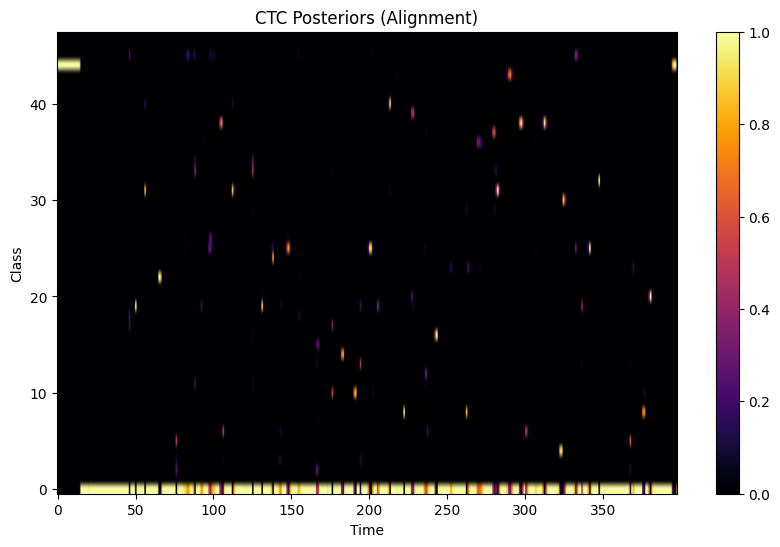

In [30]:
if viz_data is not None:
    plt.figure(figsize=(10,6))
    plt.imshow(np.exp(viz_data).T, aspect='auto', origin='lower', cmap='inferno')
    plt.title("CTC Posteriors (Alignment)")
    plt.xlabel("Time")
    plt.ylabel("Class")
    plt.colorbar()
    plt.show()